In [ ]:
import torch
import torch.nn as nn
import torch.optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from DropBackMLP import DropBackMLP
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

In [ ]:
def train(epochs: int, model: DropBackMLP, train_loader: DataLoader, val_loader: DataLoader, optim: torch.optim.SGD, criterion, device, in_size: int, freeze_epoch: int):
    train_accs = []
    val_accs = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - train"):
            images, labels = images.to(device), labels.to(device)
            optim.zero_grad()
            images = images.view(-1, in_size)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()

            train_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

        train_acc = correct / total
        train_loss /= len(train_loader)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - val"):
                images, labels = images.to(device), labels.to(device)
                images = images.view(-1, in_size)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
        
        val_acc = correct / total
        val_loss /= len(val_loader)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}:")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        if epoch == freeze_epoch - 1:
            model.freeze_params()
        if epoch >= freeze_epoch - 1:
            model.reset_frozen(device)
    return train_accs, val_accs, model

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

data = datasets.MNIST(root="data", download=False, train=True, transform=transform)
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = random_split(data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [ ]:
in_size = 28 * 28
hidden_size = 100
output_size = 10

In [ ]:
criterion = nn.CrossEntropyLoss()

def run_test(epochs, prune, freeze):
    # seed = np.random.randint(0, 10000)
    seed = 0
    model = DropBackMLP(in_size, hidden_size, output_size, prune, seed).to(device)
    optim = torch.optim.SGD(model.parameters(), lr=0.01)
    return train(epochs, model, train_loader, val_loader, optim, criterion, device, in_size, freeze)

In [ ]:
seed = 0
baseline_model = DropBackMLP(in_size, hidden_size, output_size, pruning_threshold=0, seed=0).to(device)
optim = torch.optim.SGD(baseline_model.parameters(), lr=0.01)
baseline = train(50, baseline_model, train_loader, val_loader, optim, criterion, device, in_size, freeze_epoch=1000)
plt.plot(baseline[1], label=f"baseline")
plt.title("baseline val")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.show()

In [ ]:
epochs = 50
pruning =  [.1, .25, .5, .75, .9]
freezing = [ 6,   6,  6,   6,  6]
prune_results = []

i = 0
for prune, freeze in zip(pruning, freezing):
    print(f"<=== TEST {i+1} OF {len(pruning) + 1} ===>")
    result = run_test(epochs, prune, freeze)
    prune_results.append((prune, freeze, result))
    i += 1

pruning =  [.75, .75, .75, .75, .75]
freezing = [  2,   4,   6,   8,  10]
freeze_results = []
i = 0
for prune, freeze in zip(pruning, freezing):
    print(f"<=== TEST {i+1} OF {len(pruning) + 1} ===>")
    result = run_test(epochs, prune, freeze)
    freeze_results.append((prune, freeze, result))
    i += 1

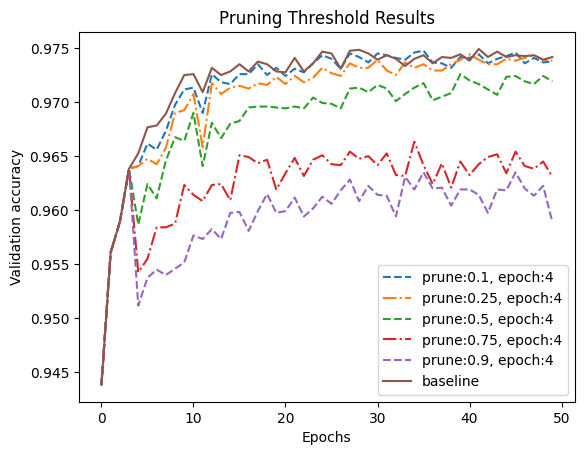

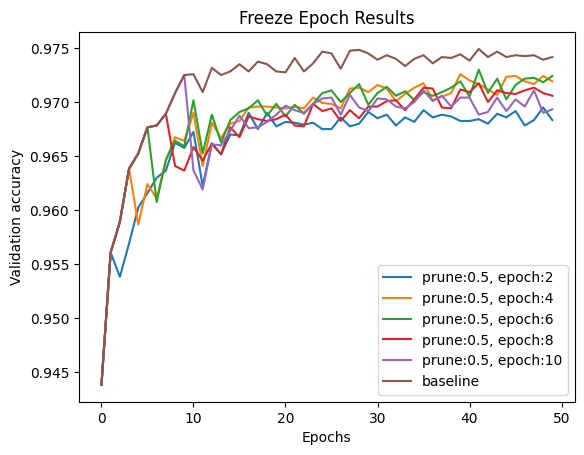

In [78]:
line_styles = ['--', '-.']
i = 0
for result in prune_results:
    plt.plot(result[2][1], label=f"prune:{result[0]}, epoch:{result[1]}", linestyle=line_styles[i % len(line_styles)])
    i += 1
plt.plot(baseline[1], label=f"baseline")
plt.title("Pruning Threshold Results")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.legend()
plt.show()

i = 0
for result in freeze_results:
    plt.plot(result[2][1], label=f"prune:{result[0]}, epoch:{result[1]}")
plt.plot(baseline[1], label=f"baseline")
plt.title("Freeze Epoch Results")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.legend()
plt.show()

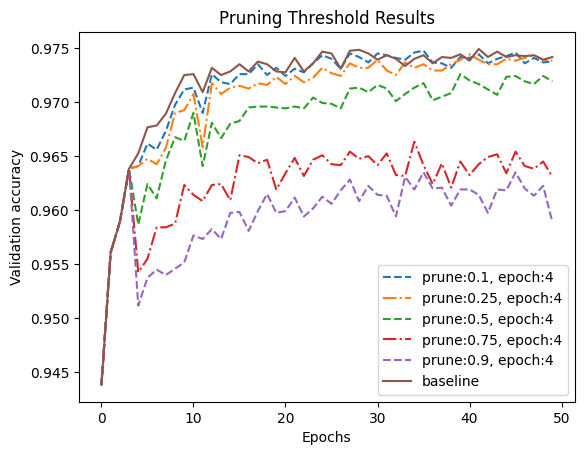

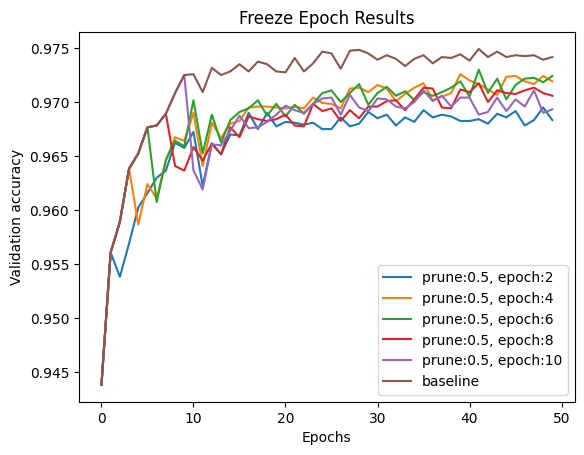

In [79]:
line_styles = ['--', '-.']
i = 0
for result in prune_results:
    plt.plot(result[2][1], label=f"prune:{result[0]}, epoch:{result[1]}", linestyle=line_styles[i % len(line_styles)])
    i += 1
plt.plot(baseline[1], label=f"baseline")
plt.title("Pruning Threshold Results")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.legend()
plt.show()

i = 0
for result in freeze_results:
    plt.plot(result[2][1], label=f"prune:{result[0]}, epoch:{result[1]}")
plt.plot(baseline[1], label=f"baseline")
plt.title("Freeze Epoch Results")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.legend()
plt.show()

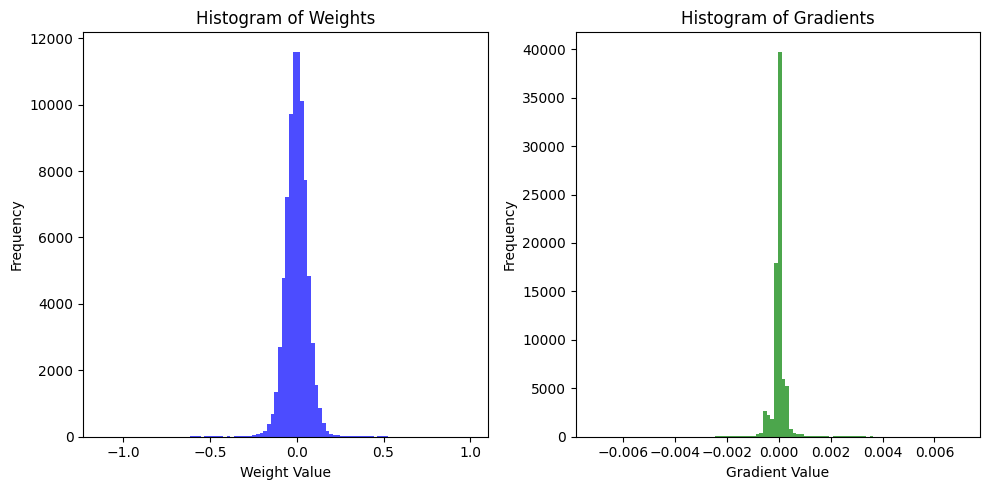

In [77]:
def plot_weight_and_gradient(model):
    weights = []
    gradients = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights.extend(param.cpu().detach().numpy().flatten())
            if param.grad is not None:
                gradients.extend(param.grad.cpu().detach().numpy().flatten())

    # Plot histogram of weights
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(weights, bins=100, color='blue', alpha=0.7)
    plt.title('Histogram of Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')

    # Plot histogram of gradients
    plt.subplot(1, 2, 2)
    plt.hist(gradients, bins=100, color='green', alpha=0.7)
    plt.title('Histogram of Gradients')
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def plot_non_frozen_histogram(model):
    non_frozen_weights = []
    non_frozen_gradients = []

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_flattened = param.cpu().detach().numpy().flatten()
            frozen_indices = model.freeze_indices
            non_frozen_weights.extend(param_flattened[~np.isin(np.arange(len(param_flattened)), frozen_indices)])
            grad_flattened = param.grad.cpu().detach().numpy().flatten()
            frozen_indices = model.freeze_indices
            non_frozen_gradients.extend(grad_flattened[~np.isin(np.arange(len(grad_flattened)), frozen_indices)])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(non_frozen_weights, bins=100, color='blue', alpha=0.7)
    plt.title('Histogram of Non-frozen Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(non_frozen_gradients, bins=100, color='green', alpha=0.7)
    plt.title('Histogram of Gradients for Non-frozen Parameters')
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')
    plt.show()

def plot_frozen_histogram(model):
    frozen_weights = []
    frozen_gradients = []

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_flattened = param.cpu().detach().numpy().flatten()
            frozen_indices = model.freeze_indices
            frozen_weights.extend(param_flattened[np.isin(np.arange(len(param_flattened)), frozen_indices)])
            grad_flattened = param.grad.cpu().detach().numpy().flatten()
            frozen_indices = model.freeze_indices
            frozen_gradients.extend(grad_flattened[np.isin(np.arange(len(grad_flattened)), frozen_indices)])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(frozen_weights, bins=100, color='blue', alpha=0.7)
    plt.title('Histogram of Frozen Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(frozen_gradients, bins=100, color='green', alpha=0.7)
    plt.title('Histogram of Gradients for Frozen Parameters')
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')
    plt.show()

def combined_histogram(model):
    non_frozen_weights = []
    non_frozen_gradients = []
    frozen_weights = []
    frozen_gradients = []

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_flattened = param.cpu().detach().numpy().flatten()
            frozen_indices = model.freeze_indices

            non_frozen_weights.extend(param_flattened[~np.isin(np.arange(len(param_flattened)), frozen_indices)])
            frozen_weights.extend(param_flattened[np.isin(np.arange(len(param_flattened)), frozen_indices)])

            grad_flattened = param.grad.cpu().detach().numpy().flatten()
            frozen_indices = model.freeze_indices
            non_frozen_gradients.extend(grad_flattened[~np.isin(np.arange(len(grad_flattened)), frozen_indices)])
            frozen_gradients.extend(grad_flattened[np.isin(np.arange(len(grad_flattened)), frozen_indices)])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(non_frozen_weights, bins=100, color='green', alpha=0.5)
    plt.hist(frozen_weights, bins=100, color='blue', alpha=0.5)
    plt.title('Histogram of Non-frozen Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(non_frozen_gradients, bins=100, color='green', alpha=0.5)
    plt.hist(frozen_gradients, bins=100, color='blue', alpha=0.5)
    plt.title('Histogram of Gradients for Non-frozen Parameters')
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')
    plt.show()



# for result in prune_results:
#     # plot_non_frozen_histogram(result[-1][-1])
#     # plot_frozen_histogram(result[-1][-1])
#     combined_histogram(result[-1][-1])

plot_weight_and_gradient(baseline_model)